# Code by Amin MESSAOUDI - Master Data & Knowledge
# Kaggle competition: data-marketing
## Leaderboard name: Amin | score: 0.58940

In [1]:
print("Let's go !")

Let's go !


## Goal

Predict for a portugues bank if these profile will subscribe or not.
https://www.kaggle.com/c/data-marketing
 
## kappa
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html

## matthews
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

# Pre-processing

Preprocess part is very import for learning part.
Here the goal is to normalize data into number. Pre-process done in training should also be done in test set also.
There is two way to pre-process in this code.
First one is by doing dummies, meaning transforming "a", "b", "c" values as bits here of size 3: 001, 010, 100 for each value.</br>

</br>
The problem here, we have unbalanced data, we have approximately 300 yes over 2700 no y values.
We will discuss about that in explaination of classifier part
</br>

</br>
Hypothesis tried : </br>
In the code below I tried to do some oversampling by duplicating yes rows (duplicated from 1 to 10) but no better result found.

In [2]:
import pandas as pand
import numpy as np

# allow to display all columns
pand.set_option('display.max_columns', None)

# loading the training set
dataset = pand.read_csv("./data/train.csv", delimiter=";", header=0)
# renaming it
trainset = dataset

print("size : ",trainset.shape)

# Tentative of Oversampling by duplicating yes
#is_yes = trainset['y'] == 'yes'
#df_try = trainset[is_yes]
#trainset = trainset.append([df_try],ignore_index='no')
#trainset = trainset.append([df_try],ignore_index='no')
#trainset = trainset.append([df_try],ignore_index='no')

# Tentative of removing a value
#trainset = trainset[trainset['poutcome'] != 'nonexistent']

trainset.shape

size :  (2999, 21)


(2999, 21)

In [3]:
# just making a copy of trainset
oldtrain = pand.read_csv("./data/train.csv", delimiter=";", header=0)
oldtrain.loc[oldtrain['y'] == 'yes', 'y'] = '1'
oldtrain.loc[oldtrain['y'] == 'no', 'y'] = '0'
#trainset.map({'yes': 1, 'no': 0})
oldtrain.y = oldtrain.y.astype(int)

In [4]:
trainset.head(1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


## Rename colums of testset according to trainset
Since headers are different a renaming of columns is necessary

In [5]:
testset = pand.read_csv("./data/test.csv", delimiter=";", header=None)

i = 0
for col in testset.columns:
    testset = testset.rename(columns={testset.columns[i]: trainset.columns[i]})
    i = i+1

print("size : ",testset.shape)
testset.head(1)

size :  (1120, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,49,management,divorced,university.degree,no,no,no,cellular,jul,thu,144,5,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1


## Undersampling tentative
Hypothesis: </br>

If we remove some rows useless, for example in pdays = 1, 2,  9, 11, 16 we don't have enough data to decide yes or no so it's seems to be better to remove them.
But here the result was not changing anything to the result output.

So the code below is commented, but could be used in future for improvements.

In [6]:
def prepre_process(df):
    df['poutcome'] = df['poutcome'].replace(['nonexistent'],'failure')
    return df
    
def undersampling(df):
    df = df[(df.pdays != 1) & (df.y != 1)]
    df = df[(df.pdays != 2) & (df.y != 1)]
    df = df[(df.pdays != 9) & (df.y != 1)]
    df = df[(df.pdays != 11) & (df.y != 1)]
    df = df[(df.pdays != 16) & (df.y != 1)]
    return df

#trainset = prepre_process(trainset)
#trainset = undersampling(trainset)
#testset = prepre_process(testset)
#testset.pdays.unique()

## Delete features func

Once we have loaded data, the goal is not learn on all the features (columns) we have.
But to found the more relevants, ones. The ones that are going to make a difference.

In [7]:
# delete columns useless, in a given df
def deleteColumns(featureToIgnore, df):
    for feature in featureToIgnore:
        if feature in df.columns:
            del df[feature]            


In [8]:
# check if values in both dataset are the same, for instance if 
# there is more values in testset this method is going to show it 
# Unicity of colum default need to be treated
# ['no' 'unknown']
# ['no' 'unknown' 'yes']
# means that we have yes values in default column, that could also be translated as 
# "we should not learn on this" column because we don't know what to do when we have yes
def checkUnique(train, test):
    for column in test.columns:
        if test[column].dtype!='int64' and test[column].dtype!='float64':
            if len(train[column].unique()) != len(test[column].unique()):
                print('Unicity of colum ' + column + ' need to be treated')
                print(trainset[column].unique())
                print(testset[column].unique())
                print('\n')

                
checkUnique(trainset, testset)

Unicity of colum education need to be treated
['basic.9y' 'high.school' 'university.degree' 'professional.course'
 'basic.6y' 'basic.4y' 'unknown']
['university.degree' 'high.school' 'basic.9y' 'professional.course'
 'unknown' 'basic.4y' 'basic.6y' 'illiterate']


Unicity of colum default need to be treated
['no' 'unknown']
['no' 'unknown' 'yes']




In [9]:
# First preprocess, change values of y yes by 1 and no by 0
# process y
trainset.loc[trainset['y'] == 'yes', 'y'] = '1'
trainset.loc[trainset['y'] == 'no', 'y'] = '0'
#trainset.map({'yes': 1, 'no': 0})
trainset.y = trainset.y.astype(int)

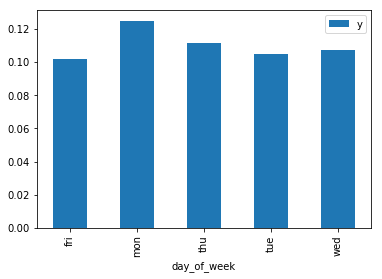

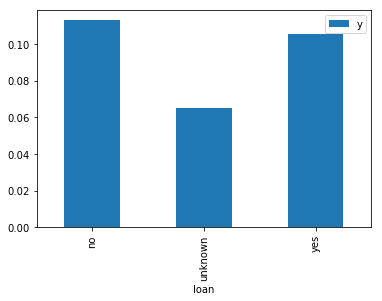

In [10]:
import matplotlib.pyplot as pyp


# Here are the features we are going to ignore in the learning part
# How did I decide this ?
# 1 - By showing plot of these columns compared to y values. If we take a look to day_of_week plot
# we can notice that the mean value for each of these day is under 0.13 meaning we can not decide
# with this column if it should be yes or no, this is going to tend to answer more "no" that yes
# since we have 0.13% of chance to be yes
# Same reasoning for loan columns and so on
# 2 - Even showing plot does not always help, for euribor3m nr.employed and cons.price.idx
# variation is to high to decide, so the solution was to tries them one by one and together to see
# impact in the prediction, but these 3 where not good for my predictions (smaller kappa and matthew)
featureToIgnore = ['campaign', 'day_of_week', 'education',
                   'cons.price.idx','euribor3m','nr.employed','default','housing',
                   'loan', 'marital','job', 'contact','emp.var.rate']

pivot = trainset.pivot_table(index="day_of_week",values="y")
pivot.plot.bar()
pivot = trainset.pivot_table(index="loan",values="y")
pivot.plot.bar()
pyp.show()

### Process features : func

In [11]:
# process a range of values from 
# @params : df the dataset, column name of column, cut_points the limits, categories names
def process_range(df,column,cut_points,categories):
    df[column+'_cat'] = pand.cut(df[column],cut_points,labels=categories)
    return df

# do mapping between values and column
# @params df dataframe, column name, mapping (dictionnary)
def process_map(df, column, mapping):
    df[column+'_cat'] = df[column].map(mapping)
    return df

# transform column into dummies
# @params df dataframe, columnname
def process_dummies(df, column):
    dummies = pand.get_dummies(df[column],prefix=column)
    deleteColumns(dummies.columns, df)
    df = pand.concat([df,dummies],axis=1)
    return df

# process duration by splitting it in interval generated automatically
# @params minimum the smallest value of range, maximum the highest, interval of generation
def process_duration(minimum,maximum,interval):
    ranges = np.arange(minimum, maximum, interval)
    arr = []
    prev = 0
    for c in ranges:
        strs =  str(prev) + '-' + str(c) 
        arr.append(strs)
        prev = c

    arr.pop()
    return ranges,arr

In [12]:
# delete features ignored
deleteColumns(featureToIgnore, trainset)
deleteColumns(featureToIgnore, testset)
tmptrain = trainset

# features remaining are age, month, duration, pdays, previous, poutcome, cons.conf.idx, y

trainset.head(1)

,age,month,duration,pdays,previous,poutcome,cons.conf.idx,y
0,30,may,487,999,0,nonexistent,-46.2,0


# ........ After deletion of features ........
# Process of feature
Here test are made before process to see if column remains.
But of course not all of them are used, I kept the code for showing what I tried before.

In [13]:
# store feature duplicated after dummies
featureDup = []

# normalize duration and previous
norm_duration = True
norm_previous = False


if norm_duration:
    ranges, arr = process_duration(minimum=-5,maximum=4000,interval=30)
    trainset = process_range(trainset,'duration',ranges,arr)
    testset = process_range(testset,'duration',ranges,arr)
    trainset = process_dummies(trainset, 'duration_cat')
    testset = process_dummies(testset, 'duration_cat')


# add duration_cat column to duplicated features
if 'duration_cat' in trainset.columns:
    featureDup.append('duration_cat')


# the cut above did not function, it was an uniform cut
'''
# process duration
trainset = process_range(trainset,'duration',[-1,364.3,728.6,1092.9,1457.2,1821.5,2185.8,2550.1,2914.4,3278.7,3643.0],
                         ["A","B","C","D","E","F","G","H","I","J"])
testset = process_range(testset,'duration',[-1,364.3,728.6,1092.9,1457.2,1821.5,2185.8,2550.1,2914.4,3278.7,3643.0],
                         ["A","B","C","D","E","F","G","H","I","J"])
trainset = process_dummies(trainset, 'duration_cat')
testset = process_dummies(testset, 'duration_cat')
'''


# process previous
if norm_previous:
    if 'previous' in trainset.columns:
        trainset = process_range(trainset,'previous',[-1,2,5,7],["Few","Lot","Much"])
        testset = process_range(testset,'previous',[-1,2,5,7],["Few","Lot","Much"])
        trainset = process_dummies(trainset, 'previous_cat')
        testset = process_dummies(testset, 'previous_cat')
        featureDup.append('previous_cat')
        featureDup.append('previous')

# explanation : we want here to regroup more likely "previous" values into 3 categories, Few, Lot, Much

# process age
if 'age' in trainset.columns:
    trainset = process_range(trainset,'age',[15,29,59,74,100],
                             ["YoungAdult","Adult","Old Adult","Senior"])
    testset = process_range(testset,'age',[15,29,59,74,100],
                             ["YoungAdult","Adult","Old Adult","Senior"])
    trainset = process_dummies(trainset, 'age_cat')
    testset = process_dummies(testset, 'age_cat')
    featureDup.append('age')
    featureDup.append('age_cat')

# explanation : create of categories of ages


# process job
if 'job' in trainset.columns:
    mappingJob = {'blue-collar':'job1', 'technician':'job1', 'housemaid':'job1',
                  'admin.':'job2', 'management':'job2', 'services':'job2',
                  'entrepreneur':'job3', 'self-employed':'job3',
                  'retired':'job4', 'unemployed':'job4', 'student':'job4',
                  'unknown':'job5'}

    trainset = process_map(trainset, 'job', mappingJob)
    testset = process_map(testset, 'job', mappingJob)
    trainset = process_dummies(trainset, 'job_cat')
    testset = process_dummies(testset, 'job_cat')
    featureDup.append('job')
    featureDup.append('job_cat')


# explanation : the idea here was to regroup most common work, like entrepreneur and self-employed into
# one group, that was a good idea working better than doing a normal dummies, but job values were not
# relevant for unbalanced data unfortunately


# process marital
if 'marital' in trainset.columns:
    trainset = process_dummies(trainset, 'marital')
    testset = process_dummies(testset, 'marital')
    marital_pivot = trainset.pivot_table(index="marital",values="y")
    featureDup.append('marital')

# explanation : dummies the marital status

# process education
if 'education' in trainset.columns:
    mappingEdu = {'basic.9y':'edu1', 'basic.6y':'edu1', 'basic.4y':'edu1',
                  'high.school':'edu2', 'university.degree':'edu2', 'professional.course':'edu2',
                  'unknown':'edu3'}
    trainset = process_map(trainset, 'education', mappingEdu)
    testset = process_map(testset, 'education', mappingEdu)
    trainset = process_dummies(trainset, 'education_cat')
    testset = process_dummies(testset, 'education_cat')
    featureDup.append('education')
    featureDup.append('education_cat')

# explanation : as job, I wanted to regroup education into categories, but education was giving bad score



# process default
if 'default' in trainset.columns:
    trainset = process_dummies(trainset, 'default')
    trainset['default_yes'] = 0
    testset = process_dummies(testset, 'default')
    featureDup.append('default')

# explanation : as explained before yes value is missing into training, I tried to add a default colum
# default_yes to uniform data but not having better results


# process housing
if 'housing' in trainset.columns:
    trainset = process_dummies(trainset, 'housing')
    testset = process_dummies(testset, 'housing')
    featureDup.append('housing')

# explanation : dummies, but not good score



# process loan
if 'housing' in trainset.columns:
    trainset = process_dummies(trainset, 'loan')
    testset = process_dummies(testset, 'loan')
    featureDup.append('housing')

# explanation : dummies, but not good score

# process contact => 1 column
if 'contact' in trainset.columns:
    trainset.loc[trainset['contact'] == 'cellular', 'contact_cat'] = int(1)
    trainset.loc[trainset['contact'] == 'telephone', 'contact_cat'] = int(0)
    testset.loc[testset['contact'] == 'cellular', 'contact_cat'] = int(1)
    testset.loc[testset['contact'] == 'telephone', 'contact_cat'] = int(0)
    featureDup.append('contact')
    
# explanation : dummies, but not good score

# process poutcome
if 'poutcome' in trainset.columns:
    trainset = process_dummies(trainset, 'poutcome')
    testset = process_dummies(testset, 'poutcome')
    featureDup.append('poutcome')

# explanation : dummies

# process month
if 'month' in trainset.columns:
    trainset = process_dummies(trainset, 'month')
    testset = process_dummies(testset, 'month')
    featureDup.append('month')

# explanation : dummies, month is used we can notice in december, march, sept, oct that values of y are high

# sorting train and testset by column name
trainset = trainset.sort_index(axis=1)
testset = testset.sort_index(axis=1)

In [14]:
# old train
oldtrain.head(1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0


In [15]:
# train before process
tmptrain.head(1)

,age,month,duration,pdays,previous,poutcome,cons.conf.idx,y,duration_cat
0,30,may,487,999,0,nonexistent,-46.2,0,445-475


In [16]:
# train after pre-process
trainset.head(1)

,age,age_cat,age_cat_Adult,age_cat_Old Adult,age_cat_Senior,age_cat_YoungAdult,cons.conf.idx,duration,duration_cat,duration_cat_-5-25,duration_cat_0--5,duration_cat_1015-1045,duration_cat_1045-1075,duration_cat_1075-1105,duration_cat_1105-1135,duration_cat_1135-1165,duration_cat_115-145,duration_cat_1165-1195,duration_cat_1195-1225,duration_cat_1225-1255,duration_cat_1255-1285,duration_cat_1285-1315,duration_cat_1315-1345,duration_cat_1345-1375,duration_cat_1375-1405,duration_cat_1405-1435,duration_cat_1435-1465,duration_cat_145-175,duration_cat_1465-1495,duration_cat_1495-1525,duration_cat_1525-1555,duration_cat_1555-1585,duration_cat_1585-1615,duration_cat_1615-1645,duration_cat_1645-1675,duration_cat_1675-1705,duration_cat_1705-1735,duration_cat_1735-1765,duration_cat_175-205,duration_cat_1765-1795,duration_cat_1795-1825,duration_cat_1825-1855,duration_cat_1855-1885,duration_cat_1885-1915,duration_cat_1915-1945,duration_cat_1945-1975,duration_cat_1975-2005,duration_cat_2005-2035,duration_cat_2035-2065,duration_cat_205-235,duration_cat_2065-2095,duration_cat_2095-2125,duration_cat_2125-2155,duration_cat_2155-2185,duration_cat_2185-2215,duration_cat_2215-2245,duration_cat_2245-2275,duration_cat_2275-2305,duration_cat_2305-2335,duration_cat_2335-2365,duration_cat_235-265,duration_cat_2365-2395,duration_cat_2395-2425,duration_cat_2425-2455,duration_cat_2455-2485,duration_cat_2485-2515,duration_cat_25-55,duration_cat_2515-2545,duration_cat_2545-2575,duration_cat_2575-2605,duration_cat_2605-2635,duration_cat_2635-2665,duration_cat_265-295,duration_cat_2665-2695,duration_cat_2695-2725,duration_cat_2725-2755,duration_cat_2755-2785,duration_cat_2785-2815,duration_cat_2815-2845,duration_cat_2845-2875,duration_cat_2875-2905,duration_cat_2905-2935,duration_cat_2935-2965,duration_cat_295-325,duration_cat_2965-2995,duration_cat_2995-3025,duration_cat_3025-3055,duration_cat_3055-3085,duration_cat_3085-3115,duration_cat_3115-3145,duration_cat_3145-3175,duration_cat_3175-3205,duration_cat_3205-3235,duration_cat_3235-3265,duration_cat_325-355,duration_cat_3265-3295,duration_cat_3295-3325,duration_cat_3325-3355,duration_cat_3355-3385,duration_cat_3385-3415,duration_cat_3415-3445,duration_cat_3445-3475,duration_cat_3475-3505,duration_cat_3505-3535,duration_cat_3535-3565,duration_cat_355-385,duration_cat_3565-3595,duration_cat_3595-3625,duration_cat_3625-3655,duration_cat_3655-3685,duration_cat_3685-3715,duration_cat_3715-3745,duration_cat_3745-3775,duration_cat_3775-3805,duration_cat_3805-3835,duration_cat_3835-3865,duration_cat_385-415,duration_cat_3865-3895,duration_cat_3895-3925,duration_cat_3925-3955,duration_cat_415-445,duration_cat_445-475,duration_cat_475-505,duration_cat_505-535,duration_cat_535-565,duration_cat_55-85,duration_cat_565-595,duration_cat_595-625,duration_cat_625-655,duration_cat_655-685,duration_cat_685-715,duration_cat_715-745,duration_cat_745-775,duration_cat_775-805,duration_cat_805-835,duration_cat_835-865,duration_cat_85-115,duration_cat_865-895,duration_cat_895-925,duration_cat_925-955,duration_cat_955-985,duration_cat_985-1015,month,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,pdays,poutcome,poutcome_failure,poutcome_nonexistent,poutcome_success,previous,y
0,30,Adult,1,0,0,0,-46.2,487,445-475,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,may,0,0,0,0,0,0,1,0,0,0,999,nonexistent,0,1,0,0,0


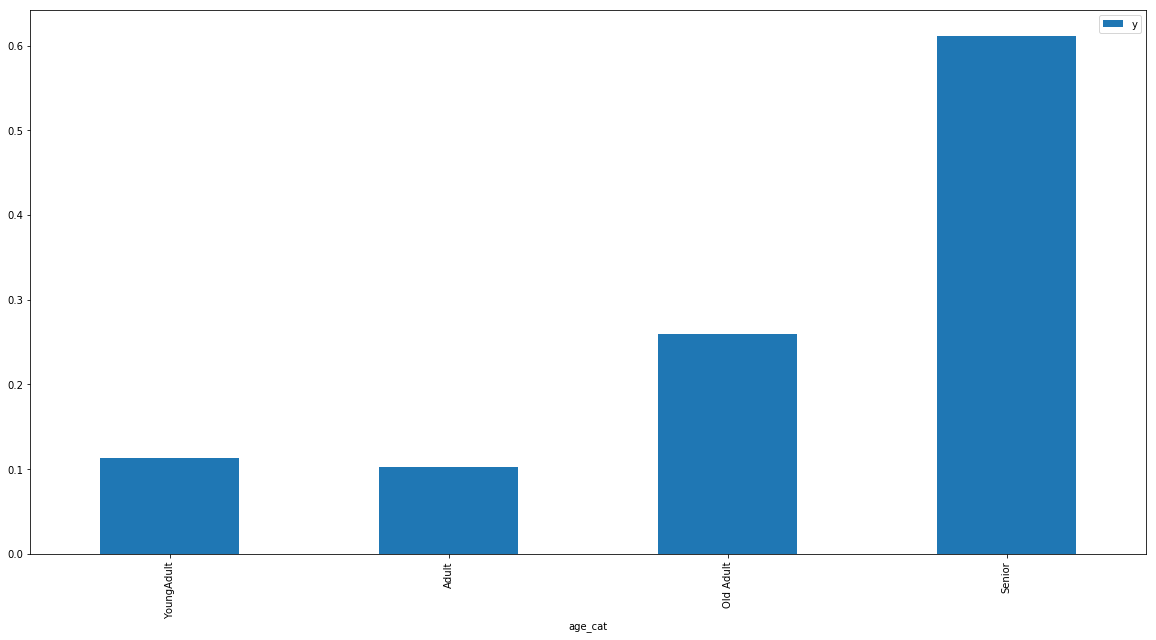

In [17]:
# again the goal here is to re-do plot to see if normalization worked well or not

pivot = trainset.pivot_table(index="age_cat",values="y")
pivot.plot.bar(figsize=(20,10))
pyp.show()

### Remove duplicate features : keep dummies

In [18]:
# we remove useless column, that we have dummies or cut
print("Deleting this duplication = ", featureDup)
deleteColumns(featureDup, trainset)
deleteColumns(featureDup, testset)

Deleting this duplication =  ['duration_cat', 'age', 'age_cat', 'poutcome', 'month']


In [19]:
# final training set
trainset.head(2)

,age_cat_Adult,age_cat_Old Adult,age_cat_Senior,age_cat_YoungAdult,cons.conf.idx,duration,duration_cat_-5-25,duration_cat_0--5,duration_cat_1015-1045,duration_cat_1045-1075,duration_cat_1075-1105,duration_cat_1105-1135,duration_cat_1135-1165,duration_cat_115-145,duration_cat_1165-1195,duration_cat_1195-1225,duration_cat_1225-1255,duration_cat_1255-1285,duration_cat_1285-1315,duration_cat_1315-1345,duration_cat_1345-1375,duration_cat_1375-1405,duration_cat_1405-1435,duration_cat_1435-1465,duration_cat_145-175,duration_cat_1465-1495,duration_cat_1495-1525,duration_cat_1525-1555,duration_cat_1555-1585,duration_cat_1585-1615,duration_cat_1615-1645,duration_cat_1645-1675,duration_cat_1675-1705,duration_cat_1705-1735,duration_cat_1735-1765,duration_cat_175-205,duration_cat_1765-1795,duration_cat_1795-1825,duration_cat_1825-1855,duration_cat_1855-1885,duration_cat_1885-1915,duration_cat_1915-1945,duration_cat_1945-1975,duration_cat_1975-2005,duration_cat_2005-2035,duration_cat_2035-2065,duration_cat_205-235,duration_cat_2065-2095,duration_cat_2095-2125,duration_cat_2125-2155,duration_cat_2155-2185,duration_cat_2185-2215,duration_cat_2215-2245,duration_cat_2245-2275,duration_cat_2275-2305,duration_cat_2305-2335,duration_cat_2335-2365,duration_cat_235-265,duration_cat_2365-2395,duration_cat_2395-2425,duration_cat_2425-2455,duration_cat_2455-2485,duration_cat_2485-2515,duration_cat_25-55,duration_cat_2515-2545,duration_cat_2545-2575,duration_cat_2575-2605,duration_cat_2605-2635,duration_cat_2635-2665,duration_cat_265-295,duration_cat_2665-2695,duration_cat_2695-2725,duration_cat_2725-2755,duration_cat_2755-2785,duration_cat_2785-2815,duration_cat_2815-2845,duration_cat_2845-2875,duration_cat_2875-2905,duration_cat_2905-2935,duration_cat_2935-2965,duration_cat_295-325,duration_cat_2965-2995,duration_cat_2995-3025,duration_cat_3025-3055,duration_cat_3055-3085,duration_cat_3085-3115,duration_cat_3115-3145,duration_cat_3145-3175,duration_cat_3175-3205,duration_cat_3205-3235,duration_cat_3235-3265,duration_cat_325-355,duration_cat_3265-3295,duration_cat_3295-3325,duration_cat_3325-3355,duration_cat_3355-3385,duration_cat_3385-3415,duration_cat_3415-3445,duration_cat_3445-3475,duration_cat_3475-3505,duration_cat_3505-3535,duration_cat_3535-3565,duration_cat_355-385,duration_cat_3565-3595,duration_cat_3595-3625,duration_cat_3625-3655,duration_cat_3655-3685,duration_cat_3685-3715,duration_cat_3715-3745,duration_cat_3745-3775,duration_cat_3775-3805,duration_cat_3805-3835,duration_cat_3835-3865,duration_cat_385-415,duration_cat_3865-3895,duration_cat_3895-3925,duration_cat_3925-3955,duration_cat_415-445,duration_cat_445-475,duration_cat_475-505,duration_cat_505-535,duration_cat_535-565,duration_cat_55-85,duration_cat_565-595,duration_cat_595-625,duration_cat_625-655,duration_cat_655-685,duration_cat_685-715,duration_cat_715-745,duration_cat_745-775,duration_cat_775-805,duration_cat_805-835,duration_cat_835-865,duration_cat_85-115,duration_cat_865-895,duration_cat_895-925,duration_cat_925-955,duration_cat_955-985,duration_cat_985-1015,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,pdays,poutcome_failure,poutcome_nonexistent,poutcome_success,previous,y
0,1,0,0,0,-46.2,487,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,999,0,1,0,0,0
1,1,0,0,0,-36.4,346,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,999,0,1,0,0,0


# ........ END PRE_PREPROCESSING ........

## Data set after pre-processing

In [20]:
trainset.shape

(2999, 155)

In [21]:
testset.shape

(1120, 154)

In [22]:
# checking the shape of training and testset
if(trainset.shape[1]-1 != testset.shape[1]):
    print('/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\')
    print('/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\')
    print('/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\ STOP /!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\')
    print('/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\')
    print('/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\/!\\')

# Preparing training + test

In [23]:
# get y column and delet it from training
trainY = trainset['y']
deleteColumns(['y'], trainset)
trainX = trainset

In [24]:
import numpy as np

# transform training into matrix (dataframe.as_matrix())
np.random.seed(0)
trainX = trainX.as_matrix()
indices = np.random.permutation(len(trainX))

In [25]:
# this code will be useless only for evaluating kappa and matthews
# but we will train on all data set

ind = 500
X_train = trainX[indices[:-ind]]
y_train = trainY[indices[:-ind]]
X_test = trainX[indices[-ind:]]
y_test = trainY[indices[-ind:]]

# Classifiers & Cross validation
The classifiers result + explanation why they have been used for Kaggle submissions:
</br>

In this part you will find the classifiers tested.
But some of them have never been published into Kaggle.
The most used are Random Forest (RF), Logistic Regression (LR) and the last one Ada Boost (ADA).
</br>
SVM have been used only for first prediction, but this one was bad.
</br>
So I invest myself into first Random Forest, I get better result but was not as accurate as what I have today.
I tried to touch the parameters as the depth and so on, without good result.
I switched to Logistic Regression (used in 98% of submissions) with balanced parameter.
Logistic regression has an ability to handle dichotomous, binary data set, that's why I used it. But the issue,
is that prediction were to much varying. we can pass from 270 to 290 to 230 predictions by changing few values from
small changes. It was to hard to predict.
The best I can had was 0.55090 and 0.58117 with Logistic regression
</br>

For the very last submission I switched to Ada Boost, to train weak learners (here decision trees) into strong ones.
Regarding our unbalanced data, a weak classifier does not mean he his bad. That's why I tried to use it.

Future works is improving it by using sample_weight parameter in fit function and give him some parameters.

</br>
Results of matthew, using 500 rows of our training set are in the bottom of notebook.

In [26]:
from sklearn.model_selection import cross_val_score
# cross validation parameter
crv = 10

# 1 - SVM
Use for first submission, one of the lowest matthews result having is by SVM.
Unfortunately I was not able to use it here in unblanced data set.

In [27]:
from sklearn import svm
from sklearn.metrics import accuracy_score

svmC = svm.SVC()
svmC.fit(trainX, trainY)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
scoreSVM = cross_val_score(svmC,trainX,trainY,cv=crv)
print("Accuracy of SVM: %0.2f (+/- %0.2f)" % (scoreSVM.mean(), scoreSVM.std() * 2))
print("Score = ", svmC.score(trainX, trainY))
scoreSVM

Accuracy of SVM: 0.90 (+/- 0.02)
Score =  0.932310770257


array([ 0.90365449,  0.91      ,  0.90666667,  0.90666667,  0.88333333,
        0.90666667,  0.90333333,  0.90666667,  0.88294314,  0.89297659])

# 2 - Stochastic Gradient Descent

In [29]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(class_weight='balanced')
sgd.fit(trainX, trainY)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [30]:
scoreSGD = cross_val_score(sgd, trainX, trainY, cv=10)
print("Accuracy of SGD: %0.2f (+/- %0.2f)" % (scoreSGD.mean(), scoreSGD.std() * 2))
print("Score = ", sgd.score(trainX, trainY))
scoreSGD

Accuracy of SGD: 0.71 (+/- 0.56)
Score =  0.306768922974


array([ 0.67109635,  0.22333333,  0.85      ,  0.88333333,  0.89333333,
        0.11      ,  0.91333333,  0.89666667,  0.81605351,  0.82943144])

# 3 - Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5, random_state=0, class_weight='balanced')
rf.fit(trainX, trainY)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [32]:
scoreRF = cross_val_score(rf,trainX,trainY,cv=crv)
print("Accuracy of RF: %0.2f (+/- %0.2f)" % (scoreRF.mean(), scoreRF.std() * 2))
print("Score = ", rf.score(trainX, trainY))
scoreRF

Accuracy of RF: 0.81 (+/- 0.08)
Score =  0.818272757586


array([ 0.76079734,  0.83666667,  0.76333333,  0.80333333,  0.83666667,
        0.83666667,  0.83333333,  0.84333333,  0.72909699,  0.84280936])

# 4 - KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier

# evaluate error of a specific knn
def evaluate_error (knn, X_test, y_test):
    #knn.predict(X_test)
    error = 1/1.0 - accuracy_score(y_test, knn.predict(X_test))/1.0
    return error

# find the lowest error and one of the bestK
def KNeighborsClassifierFunc (X_train, y_train, X_test, y_test):
    minimum_error = 1.0
    bestK = 0
    for k in range(1,100):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        error = evaluate_error(knn, X_test, y_test)
        #print(error)
        if(error < minimum_error):
            bestK = k
            minimum_error = error
    return bestK, minimum_error

#bestK, minimum = KNeighborsClassifierFunc(X_train, y_train, X_test, y_test)
#print("Best k = ", bestK, ' with an error of ', minimum)

bestK = 8

# KNN optimized
knn = KNeighborsClassifier(n_neighbors=bestK)
knn.fit(trainX, trainY)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')

In [34]:
scoreKNNO = cross_val_score(knn,trainX,trainY,cv=crv)
print("Accuracy of KNN Optimized: %0.2f (+/- %0.2f)" % (scoreKNNO.mean(), scoreKNNO.std() * 2))
print("Score = ", knn.score(trainX, trainY))
scoreKNNO

Accuracy of KNN Optimized: 0.91 (+/- 0.02)
Score =  0.918306102034


array([ 0.910299  ,  0.92      ,  0.90333333,  0.91666667,  0.89333333,
        0.91333333,  0.90333333,  0.91333333,  0.89632107,  0.89632107])

# 5 - Gradient boost

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

grd = GradientBoostingClassifier(max_features='auto')
grd.fit(trainX, trainY)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [36]:
scoreGB = cross_val_score(grd, trainX, trainY, cv=10)

print("Accuracy of SGD: %0.2f (+/- %0.2f)" % (scoreGB.mean(), scoreGB.std() * 2))
print("Score = ", grd.score(trainX, trainY))
scoreGB

Accuracy of SGD: 0.90 (+/- 0.03)
Score =  0.938646215405


array([ 0.910299  ,  0.92333333,  0.88333333,  0.90666667,  0.89      ,
        0.92      ,  0.91333333,  0.91666667,  0.88294314,  0.89632107])

# 6 - Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight

lr = LogisticRegression(penalty='l1', class_weight='balanced')
lr.fit(trainX, trainY)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [39]:
scoreLR = cross_val_score(lr,trainX,trainY,cv=crv)
print("Accuracy of RF: %0.2f (+/- %0.2f)" % (scoreLR.mean(), scoreLR.std() * 2))
print("Score = ", lr.score(trainX, trainY))
scoreLR

Accuracy of RF: 0.83 (+/- 0.05)
Score =  0.841280426809


array([ 0.82059801,  0.87333333,  0.83      ,  0.82      ,  0.80666667,
        0.86      ,  0.83333333,  0.86      ,  0.7826087 ,  0.83277592])

# 7 - Ada boost

In [40]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# base_estimator=DecisionTreeClassifier(max_depth=2)
ada = AdaBoostClassifier()
ada.fit(trainX, trainY)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [41]:
scoreADA = cross_val_score(ada, trainX, trainY, cv=10)
print("Accuracy of SGD: %0.2f (+/- %0.2f)" % (scoreADA.mean(), scoreADA.std() * 2))
print("Score = ", ada.score(trainX, trainY))
scoreADA

Accuracy of SGD: 0.90 (+/- 0.03)
Score =  0.918639546516


array([ 0.910299  ,  0.91      ,  0.86333333,  0.89333333,  0.90666667,
        0.91333333,  0.90666667,  0.91666667,  0.89966555,  0.89632107])

# Prediction

In [42]:
# display how much time yes was predicted and return output
def how_much_predict(classifier):
    output_Y = classifier.predict(testset.as_matrix())
    yes = 0
    for prediction in output_Y:
        if prediction == 1:
            yes = yes + 1
        if prediction.dtype != 'int64':
            print(prediction)
    
    print('Number of subscription predicted : ' + str(yes) + ' on ' + str(len(output_Y)))
    return output_Y


print("Logistic Regression")
how_much_predict(lr)
print("Stochast.")
# here we can notice sgd is not predicting well too much yes over no (939), we excpet a low matthew value
# (see table below)
how_much_predict(sgd)

# ADA BOOST IS THE CHOOSEN ONE
print("Ada Boost")
output_Y = how_much_predict(ada)

Logistic Regression
Number of subscription predicted : 279 on 1120
Stochast.
Number of subscription predicted : 939 on 1120
Ada Boost
Number of subscription predicted : 92 on 1120


# Compute Kappa & Matthews correlation score with some part of training test

In [43]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef

# generating matthews, kappa result into a table
dico = dict()

the_choosen = rf
kappa = cohen_kappa_score(y_test,the_choosen.predict(X_test))
matthews = matthews_corrcoef(y_test,the_choosen.predict(X_test))
dico['RF'] = { 'kappa':kappa, 'matthews':matthews}

the_choosen = knn
kappa = cohen_kappa_score(y_test,the_choosen.predict(X_test))
matthews = matthews_corrcoef(y_test,the_choosen.predict(X_test))
dico['KNN'] = { 'kappa':kappa, 'matthews':matthews}

the_choosen = svmC
kappa = cohen_kappa_score(y_test,the_choosen.predict(X_test))
matthews = matthews_corrcoef(y_test,the_choosen.predict(X_test))
dico['SVM'] = { 'kappa':kappa, 'matthews':matthews}

the_choosen = sgd
kappa = cohen_kappa_score(y_test,the_choosen.predict(X_test))
matthews = matthews_corrcoef(y_test,the_choosen.predict(X_test))
dico['SGD'] = { 'kappa':kappa, 'matthews':matthews}

the_choosen = grd
kappa = cohen_kappa_score(y_test,the_choosen.predict(X_test))
matthews = matthews_corrcoef(y_test,the_choosen.predict(X_test))
dico['GRD'] = { 'kappa':kappa, 'matthews':matthews}

the_choosen = ada
kappa = cohen_kappa_score(y_test,the_choosen.predict(X_test))
matthews = matthews_corrcoef(y_test,the_choosen.predict(X_test))
dico['ADA'] = { 'kappa':kappa, 'matthews':matthews}

the_choosen = lr
kappa = cohen_kappa_score(y_test,the_choosen.predict(X_test))
matthews = matthews_corrcoef(y_test,the_choosen.predict(X_test))
dico['LR'] = { 'kappa':kappa, 'matthews':matthews}

result = pand.DataFrame({
    'kappa':{
        'RF':dico['RF'].get('kappa'),
        'KNN':dico['KNN'].get('kappa'),
        'SVM':dico['SVM'].get('kappa'),
        'SGD':dico['SGD'].get('kappa'),
        'GRD':dico['GRD'].get('kappa'),
        'ADA':dico['ADA'].get('kappa'),
        'LR':dico['LR'].get('kappa'),
    },
    'matthews':{
        'RF':dico['RF'].get('matthews'),
        'KNN':dico['KNN'].get('matthews'),
        'SVM':dico['SVM'].get('matthews'),
        'SGD':dico['SGD'].get('matthews'),
        'GRD':dico['GRD'].get('matthews'),
        'ADA':dico['ADA'].get('matthews'),
        'LR':dico['LR'].get('matthews'),
    }
})

result.sort_values(by=['matthews'], ascending=False)

,kappa,matthews
GRD,0.595777,0.621619
SVM,0.530075,0.576651
ADA,0.516965,0.537058
LR,0.490394,0.527852
RF,0.448052,0.497615
KNN,0.417098,0.461375
SGD,0.061996,0.178856


# Result decision

At the end I decided to use ADA, SVM and GRD were ignored because giving bad result in general (SVM first submission)

In [45]:
# output result into a file
client_ids = range(1, len(output_Y)+1)

submission_Kaggle_df = {
    'prediction':output_Y
}

submission_Kaggle = pand.DataFrame(submission_Kaggle_df)
submission_Kaggle.index = np.arange(1, len(output_Y)+1)
submission_Kaggle.to_csv('data/subKaggle_MESSAOUDI_Amin.csv')

# END